<a href="https://colab.research.google.com/github/zuzka05/stat_learn/blob/main/video2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Build a Quant Trading Strategy - Part 2

In [ ]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

In [ ]:
# In the last video, we built a model that predicts what the future log return will be eight hours from now.

In [ ]:
# This video is about using our model to create a strategy based on our model's predictions

In [ ]:
# Don't worry if you haven't watched Part 1 — I'll recap the model for you.
# Your feedback really matters to me. If you enjoy this, please like and subscribe — that's my signal to know you want a Part 3.

In [ ]:
# The model uses lag 1, lag 2 and lag 3. We will go into more detail about the model.

### Strategy Types

In [ ]:
# 1 Maker strategies => they are providing liquidity => adding liquidity to a market and aim to be compensated for it
# 2 Taker strategies => they taking away liquidity => market orders that consume liquidity => what we are going to focus on

In [ ]:
# I've got another video — 'Introduction to Quantitative Trading' — that goes way deeper into taker and maker strategies.
# If you want the full breakdown, definitely watch that one. Link's below."

In [ ]:
# Key Questions for our taking strategy

# 1. Entry/Exit
# 2. Trade Sizing
# 3. Leverage

In [ ]:
#Leverage you're borrowing money. It is the risk of liquidation
#Create that maximizes stat edge - look for a model that maximizes SR

In [ ]:
## the key goal is we want to create a strategy that maximises profits from the model's statistical edge

### Import Libraries

In [3]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


###  Load Model

In [ ]:
# I changed the model as it not predicts 12 hours ahead and not 8h. The reason why ito increase our time horizon is because the fees ate too much into profits.
# Also increased the model's features to 3 from 1 - so uses the 3 most recent lags,
# We will go into more detail later


In [7]:
import models
model = models.LinearModel(3)
# security alert
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval() #more efficient for testing

LinearModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

### Model Parameters

In [ ]:
#Look at the previous log returns to predict future log returns
#It's a MR model because first 2 weights are negative

In [8]:
research.print_model_params(model)

linear.weight:
[[-0.10395038 -0.06726477  0.02827305]]
linear.bias:
[0.00067121]


### What is Mean Reversion?

In [ ]:
#We have MR times series

In [9]:
series = [-0.014000, 0.011399, -0.012212, 0.01997, -0.01442, 0.01227]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df

log_return,mean
f64,f64
-0.014,0.000501
0.011399,0.000501
-0.012212,0.000501
0.01997,0.000501
-0.01442,0.000501
0.01227,0.000501


In [ ]:
#Those are log returns, going from negative to positive. The orange line is a central tendency

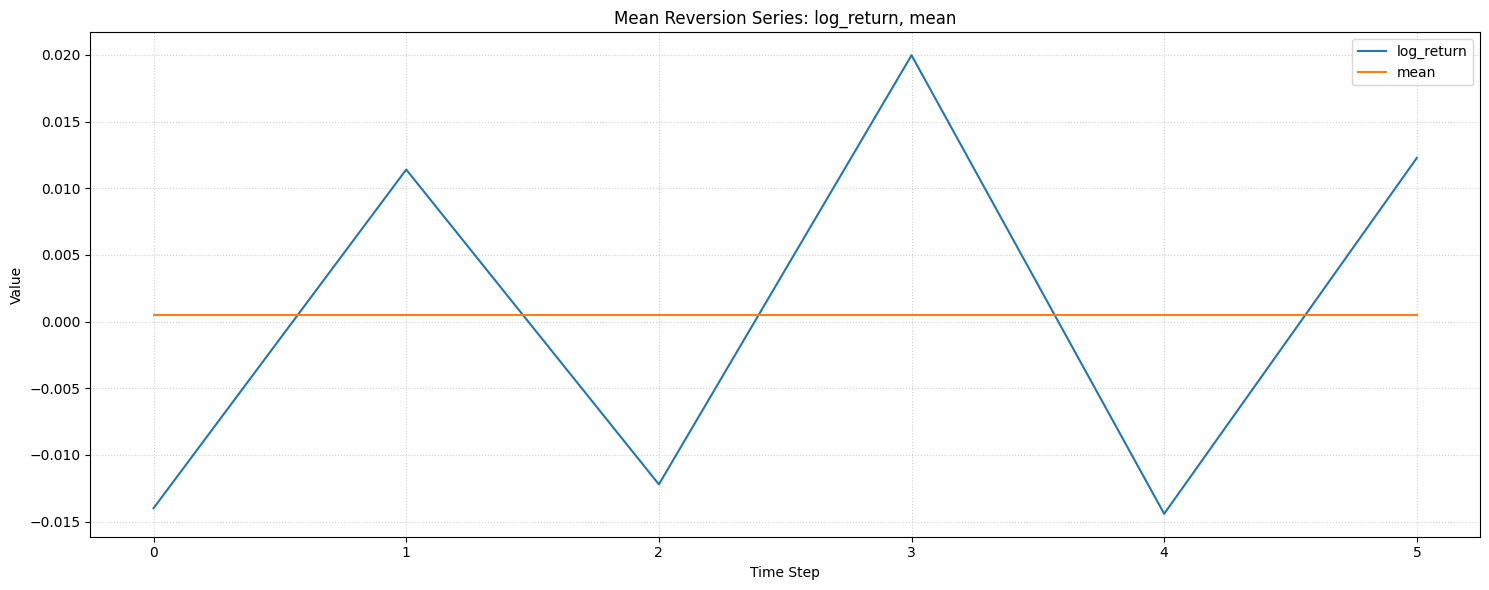

In [10]:
research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], 'Mean Reversion')

### Interpretability - Linear Model

In [ ]:
#The current log return is negative, the weight is negative so gonna flip a sign and predict positive

In [11]:
def linear_model(x):
    w, b = -0.09911217, 0.00059838
    return w * x + b

linear_model(-0.015)

0.00208506255

In [12]:
linear_model(0.02)

-0.0013838634

In [13]:
linear_model(0.000002)

0.00059818177566

In [14]:
linear_model(0.0)

0.00059838

### Interpretability - Non Linear Model

In [ ]:
#It wraps the input into a tensor. There's a weight and the bias
#It goes through the non-linear activation function
#It is mapping a bounded number between -1 and 1
#They're less interpretable

In [16]:
def nn_model(x):
    x = torch.tensor([x])
    W = torch.tensor([0.08035, -0.01478, -0.03523,  0.06777,  0.03789,  0.0013991, -0.13303,  0.8045])
    b = torch.tensor([0.16421])
    return torch.tanh(torch.sum(x * W) + b)

nn_model(-0.015)

tensor([0.1509])

In [17]:
# no interability
nn_model(0.02)

tensor([0.1785])

In [18]:
nn_model(0.0)

tensor([0.1627])

In [ ]:
# not disparaging neural networks as my background is neural networks
# but for trading, neural networks can increase your expected value but at the expense of complexity
# i tend to favour linear models because they are interpretible, are not sensitive to noise, less prone to overfit (generalization)

## Strategy Development!

### Load Time Series

In [ ]:
# binance.download_trades(sym, download_window)
#we sort it below - it's important for TS to have temportal order - ascending order

In [20]:
sym = 'BTCUSDT'
time_interval = '12h'

ts = pl.read_csv(f"{sym}_{time_interval}_ohlc.csv", try_parse_dates=True).sort('datetime')
ts

datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3
…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5


### Add Target and Features

In [ ]:
#Add a target - what we're trying to predict
#Features - what are the inputs? How do we engineer them?
#Forecast_horizon =1, it is 12h time series, predict future log return 12h ahead of time, 1 step at a time
#We're predicting close_log_return based on the previous log_returns, which are just lags
#Here we're using 3 lags

In [21]:
sym = 'BTCUSDT'
forecast_horizon = 1
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=3)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1,null,null,null,null
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5,0.018025,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0,-0.010288,0.018025,null,null
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0,0.004905,-0.010288,0.018025,null
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3,-0.001877,0.004905,-0.010288,0.018025
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### Time Split

In [ ]:
#When we train the data we split it by time

In [ ]:
test_size = 0.25
_, trades = research.timeseries_split(ts, test_size)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


## Strategy Decision # 1: Entry / Exit Signal

In [ ]:
# q1: when do we get in? entry signal
# q2: when do we get out? exit signal

In [ ]:
# 1. Time Based
# 2. Predicate Based

In [ ]:
# predicate example => we only want to trade if our y_hat is above or below a certain threshold

In [ ]:
# time based => each row represents a roundtrip trade. trade to open position at start of interval, trade to close the position at end of interval. each row = 2 trades.

In [ ]:
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### Add Model's Predictions

In [ ]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2',f'{target}_lag_3']
trades = research.add_model_predictions(trades, model, features)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259,0.004543
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743,0.001263
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844,-0.001228
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349,0.000388
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597,0.001554
…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011


### Add Directional Signal

In [ ]:
trades = trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259,0.004543,1.0
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743,0.001263,1.0
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844,-0.001228,-1.0
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349,0.000388,1.0
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597,0.001554,1.0
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0


### Calculate Trade Log Return

In [ ]:
trades = trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259,0.004543,1.0,0.005349
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743,0.001263,1.0,0.008597
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844,-0.001228,-1.0,0.001385
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349,0.000388,1.0,-0.005257
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597,0.001554,1.0,0.010185
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347


### Calculate Cumulative Trade Log Return

In [ ]:
trades = trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259,0.004543,1.0,0.005349,0.005349
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743,0.001263,1.0,0.008597,0.013946
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844,-0.001228,-1.0,0.001385,0.015332
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349,0.000388,1.0,-0.005257,0.010075
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597,0.001554,1.0,0.010185,0.02026
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.227467
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.240078
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.243425


### Display Equity Curve (Log Space)

In [ ]:
research.plot_column(trades, 'cum_trade_log_return')

alt.Chart(...)

## Key Strategy Decision #2: Trade Sizing

In [ ]:
# 1. Constant Trade Size
# 2. Compounding Trade Size

In [ ]:
capital = 100
ratio = 1.0 # you could experiment with different ratios like kelly criterion
trade_value = ratio * capital

# entry trade value and exit trade value
trades = trades.with_columns(
    pl.lit(trade_value).alias('entry_trade_value'),
    (trade_value * pl.col('trade_log_return').exp()).alias('exit_trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty'),
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty'),
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty
datetime[μs],f64,f64,f64,f32,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,0.004543,100.0,100.536332,0.000854
2025-07-16 00:00:00,117738.6,118755.1,0.008597,0.001263,100.0,100.863439,0.000849
2025-07-16 12:00:00,118755.1,118590.7,0.001385,-0.001228,100.0,100.138628,-0.000842
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,0.000388,100.0,99.475676,0.000843
2025-07-17 12:00:00,117968.8,119176.6,0.010185,0.001554,100.0,101.023744,0.000848
…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,0.000779,100.0,97.499381,0.000804
2025-10-08 00:00:00,121286.6,122825.7,0.012611,0.003535,100.0,101.269061,0.000824
2025-10-08 12:00:00,122825.8,123237.5,0.003347,0.001011,100.0,100.335272,0.000814


### Add Trade Gross PnL

In [ ]:
trades = trades.with_columns((pl.col('exit_trade_value') - pl.col('entry_trade_value')).alias('trade_gross_pnl'))
trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', )

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty
datetime[μs],f64,f64,f64,f32,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,0.004543,100.0,100.536332,0.000854
2025-07-16 00:00:00,117738.6,118755.1,0.008597,0.001263,100.0,100.863439,0.000849
2025-07-16 12:00:00,118755.1,118590.7,0.001385,-0.001228,100.0,100.138628,-0.000842
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,0.000388,100.0,99.475676,0.000843
2025-07-17 12:00:00,117968.8,119176.6,0.010185,0.001554,100.0,101.023744,0.000848
…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,0.000779,100.0,97.499381,0.000804
2025-10-08 00:00:00,121286.6,122825.7,0.012611,0.003535,100.0,101.269061,0.000824
2025-10-08 12:00:00,122825.8,123237.5,0.003347,0.001011,100.0,100.335272,0.000814


### Add Transaction Fees

In [ ]:
taker_fee = binance.TAKER_FEE
maker_fee = binance.MAKER_FEE

trades = trades.with_columns(
    (pl.col('entry_trade_value') * taker_fee + pl.col('exit_trade_value') * taker_fee).alias('taker_fee'),
    (pl.col('entry_trade_value') * maker_fee + pl.col('exit_trade_value') * maker_fee).alias('maker_fee')
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', 'trade_gross_pnl','maker_fee','taker_fee')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl,maker_fee,taker_fee
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,0.004543,100.0,100.536332,0.000854,0.536332,0.020054,0.060161
2025-07-16 00:00:00,117738.6,118755.1,0.008597,0.001263,100.0,100.863439,0.000849,0.863439,0.020086,0.060259
2025-07-16 12:00:00,118755.1,118590.7,0.001385,-0.001228,100.0,100.138628,-0.000842,0.138628,0.020014,0.060042
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,0.000388,100.0,99.475676,0.000843,-0.524324,0.019948,0.059843
2025-07-17 12:00:00,117968.8,119176.6,0.010185,0.001554,100.0,101.023744,0.000848,1.023744,0.020102,0.060307
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,0.000779,100.0,97.499381,0.000804,-2.500619,0.01975,0.05925
2025-10-08 00:00:00,121286.6,122825.7,0.012611,0.003535,100.0,101.269061,0.000824,1.269061,0.020127,0.060381
2025-10-08 12:00:00,122825.8,123237.5,0.003347,0.001011,100.0,100.335272,0.000814,0.335272,0.020034,0.060101


### Calculate Trade Net PnL

In [ ]:
trades = trades.with_columns(
    (pl.col('trade_gross_pnl')-pl.col('taker_fee')).alias('trade_net_taker_pnl'),
    (pl.col('trade_gross_pnl')-pl.col('maker_fee')).alias('trade_net_maker_pnl'),
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', 'trade_gross_pnl','trade_net_taker_pnl','trade_net_maker_pnl')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl,trade_net_taker_pnl,trade_net_maker_pnl
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,0.004543,100.0,100.536332,0.000854,0.536332,0.476171,0.516278
2025-07-16 00:00:00,117738.6,118755.1,0.008597,0.001263,100.0,100.863439,0.000849,0.863439,0.80318,0.843353
2025-07-16 12:00:00,118755.1,118590.7,0.001385,-0.001228,100.0,100.138628,-0.000842,0.138628,0.078586,0.118614
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,0.000388,100.0,99.475676,0.000843,-0.524324,-0.584167,-0.544272
2025-07-17 12:00:00,117968.8,119176.6,0.010185,0.001554,100.0,101.023744,0.000848,1.023744,0.963437,1.003642
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,0.000779,100.0,97.499381,0.000804,-2.500619,-2.559869,-2.520369
2025-10-08 00:00:00,121286.6,122825.7,0.012611,0.003535,100.0,101.269061,0.000824,1.269061,1.208681,1.248934
2025-10-08 12:00:00,122825.8,123237.5,0.003347,0.001011,100.0,100.335272,0.000814,0.335272,0.275171,0.315238


### Display Equity Curves for Constant Sizing

In [ ]:
def equity_curve(capital, col_name, suffix):
    return (capital + (pl.col(col_name).cum_sum())).alias(f'equity_curve_{suffix}')

trades = trades.with_columns(
    equity_curve(capital, 'trade_net_taker_pnl', 'taker'),
    equity_curve(capital, 'trade_net_maker_pnl', 'maker'),
    equity_curve(capital, 'trade_gross_pnl', 'gross'),
)
trades.select('datetime','equity_curve_gross','equity_curve_taker','equity_curve_maker')

datetime,equity_curve_gross,equity_curve_taker,equity_curve_maker
datetime[μs],f64,f64,f64
2025-07-15 12:00:00,100.536332,100.476171,100.516278
2025-07-16 00:00:00,101.39977,101.27935,101.35963
2025-07-16 12:00:00,101.538398,101.357937,101.478245
2025-07-17 00:00:00,101.014074,100.77377,100.933973
2025-07-17 12:00:00,102.037818,101.737207,101.937615
…,…,…,…
2025-10-07 12:00:00,123.624693,113.477606,120.242331
2025-10-08 00:00:00,124.893754,114.686286,121.491265
2025-10-08 12:00:00,125.229026,114.961458,121.806503


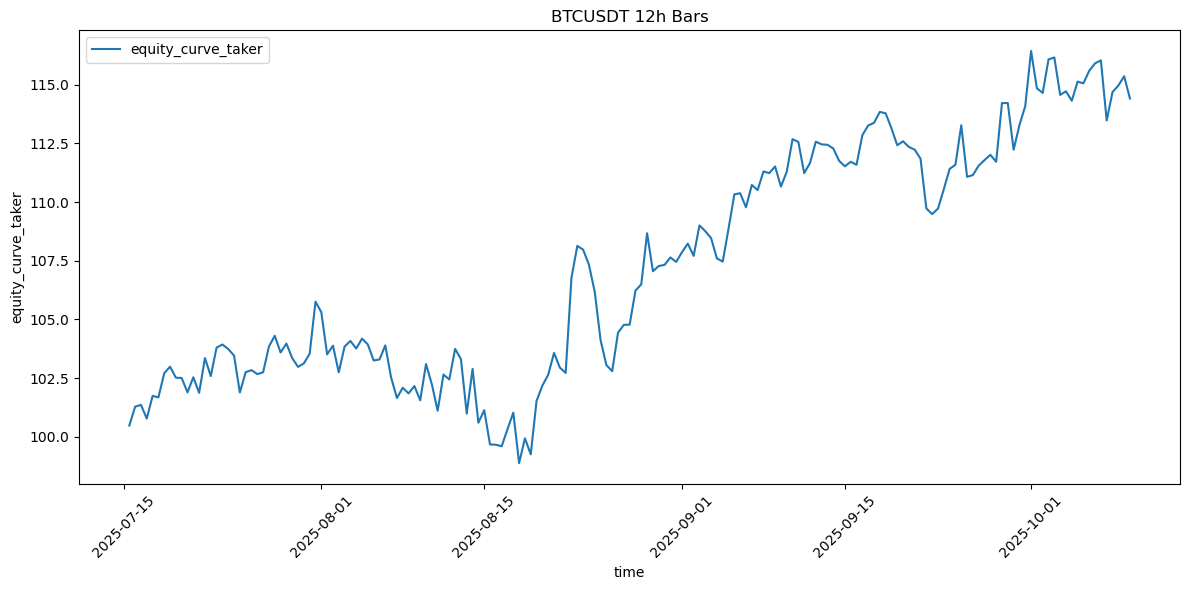

In [ ]:
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

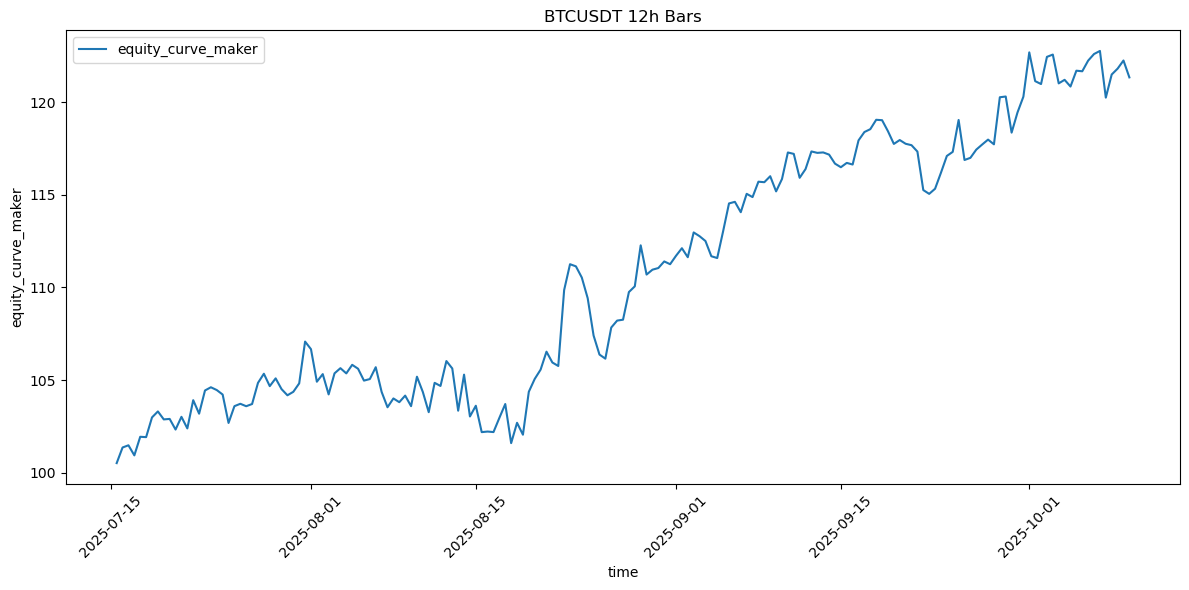

In [ ]:
research.plot_static_timeseries(trades, sym, 'equity_curve_maker', time_interval)

### Calculate Total Net Return using Constant Sizing

In [ ]:
constant_sizing_net_return = trades['equity_curve_taker'][-1] / capital - 1
constant_sizing_net_return

0.14410358892170327

## experiment with compounding trade sizes

In [ ]:
# 2 => 102 (100 + 2)
# 1 => 103 (100 + 2 + 1)
# -1 => 102 (100 + 2 + 1 - 1)

In [ ]:
log_return_1 = 0.005439
pnl1 = capital * np.exp(log_return_1)
pnl1

np.float64(100.54538182137402)

In [ ]:
log_return_2 = 0.008597
pnl2 = pnl1 * np.exp(log_return_2)
pnl2

np.float64(101.41349671401576)

In [ ]:
log_return_3 = 0.001385
pnl3 = pnl2 * np.exp(log_return_3)
pnl3

np.float64(101.55405171883751)

In [ ]:
((capital * np.exp(0.005349)) * np.exp(0.008597)) * np.exp(0.001385)

np.float64(101.5449122654644)

### Time Addivitivity

In [ ]:
capital * np.exp(log_return_1 + log_return_2 + log_return_3)

np.float64(101.55405171883751)

### Add Compounding Trade Sizes

In [ ]:
trades = trades.with_columns(
    ((pl.col('cum_trade_log_return').exp()) * capital).shift().fill_null(capital).alias('entry_trade_value'),
    ((pl.col('cum_trade_log_return').exp()) * capital).alias('exit_trade_value'),
).with_columns(
    (pl.col('entry_trade_value') / pl.col('open') * pl.col('dir_signal')).alias('signed_trade_qty'),
    (pl.col('exit_trade_value')-pl.col('entry_trade_value')).alias('trade_gross_pnl'),
)
trades.select('datetime','open','close','trade_log_return','entry_trade_value','exit_trade_value','signed_trade_qty','trade_gross_pnl')

datetime,open,close,trade_log_return,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,100.0,100.536332,0.000854,0.536332
2025-07-16 00:00:00,117738.6,118755.1,0.008597,100.536332,101.404401,0.000854,0.86807
2025-07-16 12:00:00,118755.1,118590.7,0.001385,101.404401,101.544976,-0.000854,0.140575
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,101.544976,101.012551,0.000856,-0.532425
2025-07-17 12:00:00,117968.8,119176.6,0.010185,101.012551,102.046662,0.000856,1.03411
…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,128.761487,125.541653,0.001035,-3.219834
2025-10-08 00:00:00,121286.6,122825.7,0.012611,125.541653,127.134854,0.001035,1.5932
2025-10-08 12:00:00,122825.8,123237.5,0.003347,127.134854,127.561101,0.001035,0.426247


### Add Transaction Fees

In [ ]:
trades = research.add_tx_fees(trades, binance.MAKER_FEE, binance.TAKER_FEE)
trades.select('datetime','entry_trade_value','exit_trade_value','tx_fee_maker','tx_fee_taker')

datetime,entry_trade_value,exit_trade_value,tx_fee_maker,tx_fee_taker
datetime[μs],f64,f64,f64,f64
2025-07-15 12:00:00,100.0,100.536332,0.020054,0.060161
2025-07-16 00:00:00,100.536332,101.404401,0.020194,0.060582
2025-07-16 12:00:00,101.404401,101.544976,0.020295,0.060885
2025-07-17 00:00:00,101.544976,101.012551,0.020256,0.060767
2025-07-17 12:00:00,101.012551,102.046662,0.020306,0.060918
…,…,…,…,…
2025-10-07 12:00:00,128.761487,125.541653,0.02543,0.076291
2025-10-08 00:00:00,125.541653,127.134854,0.025268,0.075803
2025-10-08 12:00:00,127.134854,127.561101,0.02547,0.076409


### Add Trade Net PnL

In [ ]:
trades = trades.with_columns(
    (pl.col('trade_gross_pnl') - pl.col('tx_fee_taker')).alias('trade_net_taker_pnl')
)
trades.select('datetime','open','close','close_log_return','y_hat','entry_trade_value','exit_trade_value','trade_gross_pnl','trade_net_taker_pnl')

datetime,open,close,close_log_return,y_hat,entry_trade_value,exit_trade_value,trade_gross_pnl,trade_net_taker_pnl
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,117738.5,0.005349,0.004543,100.0,100.536332,0.536332,0.476171
2025-07-16 00:00:00,117738.6,118755.1,0.008597,0.001263,100.536332,101.404401,0.86807,0.807488
2025-07-16 12:00:00,118755.1,118590.7,-0.001385,-0.001228,101.404401,101.544976,0.140575,0.07969
2025-07-17 00:00:00,118590.7,117968.9,-0.005257,0.000388,101.544976,101.012551,-0.532425,-0.593192
2025-07-17 12:00:00,117968.8,119176.6,0.010185,0.001554,101.012551,102.046662,1.03411,0.973193
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,0.000779,128.761487,125.541653,-3.219834,-3.296125
2025-10-08 00:00:00,121286.6,122825.7,0.012611,0.003535,125.541653,127.134854,1.5932,1.517398
2025-10-08 12:00:00,122825.8,123237.5,0.003347,0.001011,127.134854,127.561101,0.426247,0.349839


### Display Equity Curve (Compounding)

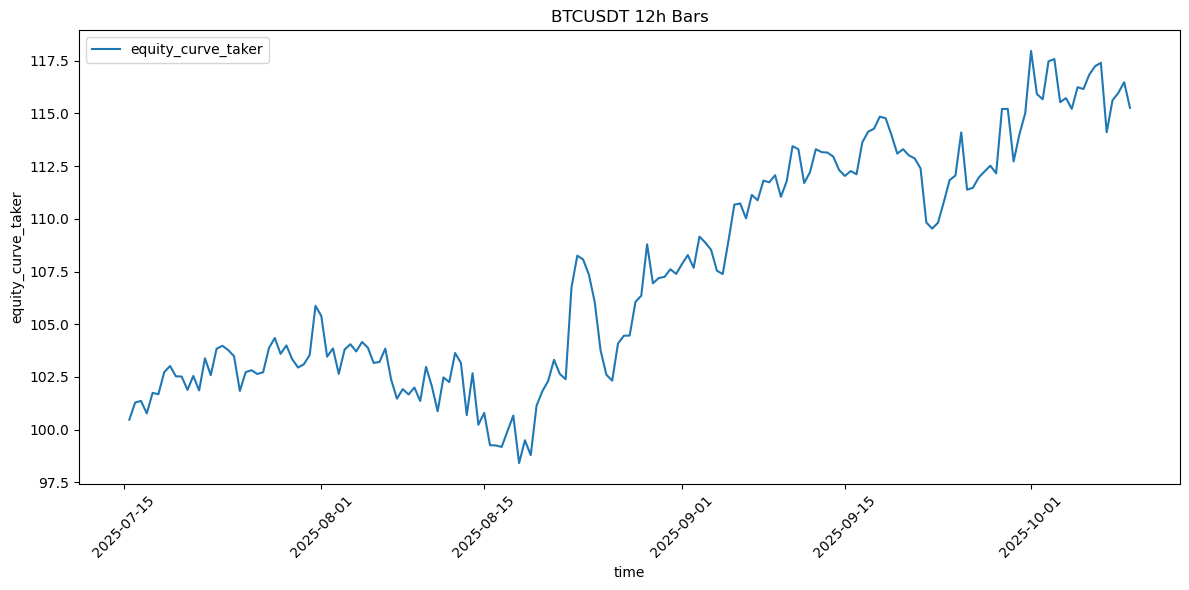

In [ ]:
trades = research.add_equity_curve(trades, capital, 'trade_net_taker_pnl', 'taker')
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

### Calculate Total Net Return for Compounding Trade Sizing

In [ ]:
compound_total_net_return = trades['equity_curve_taker'][-1] / capital - 1
compound_total_net_return

0.152678457612067

In [ ]:
constant_sizing_net_return

0.14410358892170327

In [ ]:
np.round(compound_total_net_return - constant_sizing_net_return, 2)

np.float64(0.01)

## Key Strategy Decision #3: Leverage

In [ ]:
# leverage is borrowing money to increase our profits

In [ ]:
leverage = 4
leverage * capital

400

In [ ]:
# in theory, we are multiplying our trade size to increase our returns

In [ ]:
# we are not multiplying our trade returns

In [ ]:
# just remember, it amplifies BOTH your profit and losses so it's important to have a postive expected value

In [ ]:
# leverage only works when you have a high Sharpe model. The more risk you reduce, the more you reduce drawdowns and more leverage you can use

In [ ]:
# key decision 3: should we use leverage? if so, how much? What's the sweet spot?

In [ ]:
# It's not a golden utopia to multiplying profits, because it can easily wipe you out

In [ ]:
trades = research.add_compounding_trades(trades, capital, leverage, maker_fee, taker_fee)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,entry_trade_value,exit_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl,equity_curve_taker,equity_curve_maker,equity_curve_gross,tx_fee_maker,tx_fee_taker
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,0.005349,-0.022844,-0.013743,0.020259,0.004543,1.0,0.005349,0.005349,400.0,402.145326,0.000854,0.003416,2.145326,0.060161,0.020054,1.904683,2.065112,101.904683,102.065112,102.145326,0.080215,0.240644
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,0.008597,0.005349,-0.022844,-0.013743,0.001263,1.0,0.008597,0.013946,402.145326,405.617605,0.000849,0.003416,3.472279,0.060259,0.020086,3.22995,3.391503,105.134633,105.456614,105.617605,0.080776,0.242329
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,-0.001385,0.008597,0.005349,-0.022844,-0.001228,-1.0,0.001385,0.015332,405.617605,406.179905,0.000842,-0.003416,0.5623,0.060042,0.020014,0.318761,0.48112,105.453393,105.937735,106.179905,0.08118,0.243539
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,-0.005257,-0.001385,0.008597,0.005349,0.000388,1.0,-0.005257,0.010075,406.179905,404.050205,0.000843,0.003425,-2.1297,0.059843,0.019948,-2.372769,-2.210723,103.080624,103.727011,104.050205,0.081023,0.243069
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,0.010185,-0.005257,-0.001385,0.008597,0.001554,1.0,0.010185,0.02026,404.050205,408.186646,0.000848,0.003425,4.136441,0.060307,0.020102,3.89277,4.055218,106.973394,107.782229,108.186646,0.081224,0.243671
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.227467,515.045949,502.166612,0.000804,0.00414,-12.879337,0.05925,0.01975,-13.184501,-12.981058,156.436727,186.923317,202.166612,0.101721,0.305164
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.240078,502.166612,508.539414,0.000824,0.00414,6.372802,0.060381,0.020127,6.06959,6.271731,162.506317,193.195048,208.539414,0.101071,0.303212
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.243425,508.539414,510.244404,0.000814,0.00414,1.70499,0.060101,0.020034,1.399354,1.603111,163.905672,194.79816,210.244404,0.101878,0.305635


In [ ]:
trades['equity_curve_taker'][-1] / capital - 1

0.610713830448268

## What if we increase to 8x leverage?

In [ ]:
trades = research.add_compounding_trades(trades, capital, 8, maker_fee, taker_fee)

In [ ]:
trades['equity_curve_taker'][-1] / capital - 1

1.2214276608965364

In [ ]:
# reason for this huge return is the combination of model's edge, compounding and leverage

In [ ]:
# this is possible on a small scale because we trading such small size that we are not moving markets around

In [ ]:
# show win rate to show there's no manipulation to make the PnL look good

### Win Rate hasn't changed

In [ ]:
trades.select((pl.col("trade_log_return") > 0).mean())

trade_log_return
f64
0.560694


### Factor Liquidation (price moves against us too much)

In [ ]:
# Liquidation is when we go bust. If use too much leverage, then a small price change can wipe us out.

In [ ]:
# leverage is a double edged sword. you can amplify profits, but too much leverage and you can wipe out all your money

In [ ]:
# Equity = Maintenance Margin
# calulcation differs from different exchanges

In [ ]:
maintenance_margin = 0.005

def long_liquidation_price(p, l, mmr):
    return (p * l) / (l + 1 - mmr * l)

def short_liquidation_price(p, l, mmr):
    return (p * l) / (l - 1 + mmr * l)

### show how leverage affects long positions

In [ ]:
long_liquidation_price(200, 2, maintenance_margin)

133.7792642140468

In [ ]:
long_liquidation_price(200, 4, maintenance_margin)

160.64257028112448

In [ ]:
long_liquidation_price(200, 10, maintenance_margin)

182.64840182648402

In [ ]:
long_liquidation_price(200, 50, maintenance_margin)

197.04433497536945

### show how leverage affects short positions

In [ ]:
short_liquidation_price(200, 2, maintenance_margin)

396.03960396039605

In [ ]:
short_liquidation_price(200, 4, maintenance_margin)

264.9006622516556

In [ ]:
short_liquidation_price(200, 10, maintenance_margin)

220.99447513812152

In [ ]:
short_liquidation_price(200, 60, maintenance_margin)

202.36087689713324

### Add Liquidation Prices

In [ ]:
leverage

4

In [ ]:

trades = trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)  # long position
      .then(
          (pl.col("open") * leverage)
          / (leverage + 1 - maintenance_margin * leverage)
      )
      .when(pl.col("dir_signal") == -1)  # short position
      .then(
          (pl.col("open") * leverage)
          / (leverage - 1 + maintenance_margin * leverage)
      )
      .otherwise(None)
      .alias("liquidation_price")
)
trades.select('datetime','open','high','low','close','liquidation_price','dir_signal')

datetime,open,high,low,close,liquidation_price,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f32
2025-07-15 12:00:00,117110.4,118499.8,115678.1,117738.5,94064.578313,1.0
2025-07-16 00:00:00,117738.6,119299.9,117017.1,118755.1,94569.156627,1.0
2025-07-16 12:00:00,118755.1,120100.0,118156.0,118590.7,157291.523179,-1.0
2025-07-17 00:00:00,118590.7,119216.4,117663.6,117968.9,95253.574297,1.0
2025-07-17 12:00:00,117968.8,120951.5,117412.8,119176.6,94754.056225,1.0
…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,99917.349398,1.0
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,97418.955823,1.0
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,98655.261044,1.0


### Add Liquidation Flag

In [ ]:
trades = trades.with_columns([
    # Worst price based on direction
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("low"))
      .otherwise(pl.col("high"))
      .alias("worst_price"),

    # Liquidation flag
    pl.when(
        (pl.col("dir_signal") == 1) & (pl.col("low") <= pl.col("liquidation_price"))
    )
    .then(True)
    .when(
        (pl.col("dir_signal") == -1) & (pl.col("high") >= pl.col("liquidation_price"))
    )
    .then(True)
    .otherwise(False)
    .alias("liquidated")
])
trades.select('datetime','open','low','high','close','dir_signal','worst_price','liquidation_price','liquidated')

datetime,open,low,high,close,dir_signal,worst_price,liquidation_price,liquidated
datetime[μs],f64,f64,f64,f64,f32,f64,f64,bool
2025-07-15 12:00:00,117110.4,115678.1,118499.8,117738.5,1.0,115678.1,94064.578313,false
2025-07-16 00:00:00,117738.6,117017.1,119299.9,118755.1,1.0,117017.1,94569.156627,false
2025-07-16 12:00:00,118755.1,118156.0,120100.0,118590.7,-1.0,120100.0,157291.523179,false
2025-07-17 00:00:00,118590.7,117663.6,119216.4,117968.9,1.0,117663.6,95253.574297,false
2025-07-17 12:00:00,117968.8,117412.8,120951.5,119176.6,1.0,117412.8,94754.056225,false
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,120516.0,125098.0,121286.5,1.0,120516.0,99917.349398,false
2025-10-08 00:00:00,121286.6,121005.3,123150.0,122825.7,1.0,121005.3,97418.955823,false
2025-10-08 12:00:00,122825.8,121607.8,124170.6,123237.5,1.0,121607.8,98655.261044,false


### Find Liquidated Trades

In [ ]:
trades.filter(pl.col("liquidated") == True)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,entry_trade_value,exit_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl,equity_curve_taker,equity_curve_maker,equity_curve_gross,tx_fee_maker,tx_fee_taker,liquidation_price,worst_price,liquidated
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool


In [ ]:
# second part finished
# third part is coding this all up and putting this all into action - where i am going to put this live with small amount of money

# topics we haven't covered - this is just a foundation to build upon
# alpha decay (also known as model drift) => where the prediction performance drifts =>
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# funding fees/rebates
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)

# please like and subscribe as this is my feedback signal to know that you want a final video in this series
# feel free to leave a comment dowb below - your feedback is very important.

# i really enjoyed making this video and hope you like it too.

# Over and out